## 卷积神经网络用于灰度图像处理

对灰度图进行平滑卷积

In [1]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.4.3
IPython 5.3.0

tensorflow 1.0.1
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.9.8-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# 这里是 Tensorflow 用文件队列的形式进行文件读取的代码
# 文件队列的好处是可以异步读取数据，这样可以『多线程』进行工作
filenames = ['lena512.png']
filename_queue = tf.train.string_input_producer(filenames)

reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

images = tf.image.decode_png(value, channels=1)

images 为 uint8 类型的 tensor. uint8 为 8 bits unsigned integer.

tensorflow 中与图像处理有关的接口可见: [Images  |  TensorFlow](https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding)

其中, png 的编码和解码分别为:
* tf.image.encode_png
* tf.image.decode_png

Tensorflow 中图片信息的存储数据类型有两种:
> Internally, images are either stored in as one float32 per channel per pixel (implicitly, values are assumed to lie in [0,1)) or one uint8 per channel per pixel (values are assumed to lie in [0,255]).

tf.nn.conv2d 可用于实现卷积计算. 注意参数 input 接收的类型是 `half`, `float32`, `float64`. 因此, 我们需要用 `tf.image.convert_image_dtype` 来将 uint8 转换为 float 类型.

In [5]:
with tf.Session() as sess:    
    # 文件队列异步读取进队列的一些操作，开始读取
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    before_image = sess.run(images)  # 512 x 512 x 1 的 numpy 数组
    print('* before_image:', before_image.shape)
    
    # 因为 conv2d 要求的是一个 4维的输入，这里用 expand_dim 扩展一维 (batch)
    input_ = tf.expand_dims(before_image, 0)
    print('* input:', input_)
    
    #------- 卷积操作，对图像进行平滑，并保存平滑后的图像, 在最后进行展示 -------#
    
    weights = np.zeros([10, 10], dtype=float)
    weights[:] = 0.01
    filter_ = tf.expand_dims(tf.expand_dims(weights, -1), -1)
    filter_ = tf.cast(filter_, tf.float32)
    print('* filter:', filter_)
    
    output = tf.nn.conv2d(input_, filter_, [1,1,1,1], 'VALID')
    output_value = sess.run(output)
    after_image = output_value[0, :, :, :]
    print('* after_image:', after_image.shape)
    
    # 停止读取
    coord.request_stop()
    coord.join(threads)

* before_image: (512, 512, 1)
* input: Tensor("ExpandDims:0", shape=(1, 512, 512, 1), dtype=float32)
* filter: Tensor("Cast:0", shape=(10, 10, 1, 1), dtype=float32)
* after_image: (503, 503, 1)


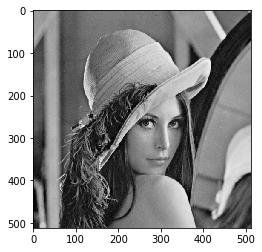

In [6]:
plt.imshow(before_image[:, :, 0], cmap='gray');

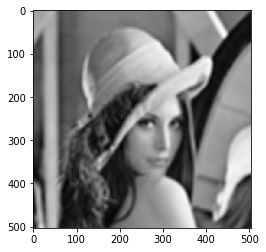

In [7]:
plt.imshow(after_image[:, :, 0], cmap='gray');